Expected steps: 15, Actual trajectory shape: (32, 14, 3)


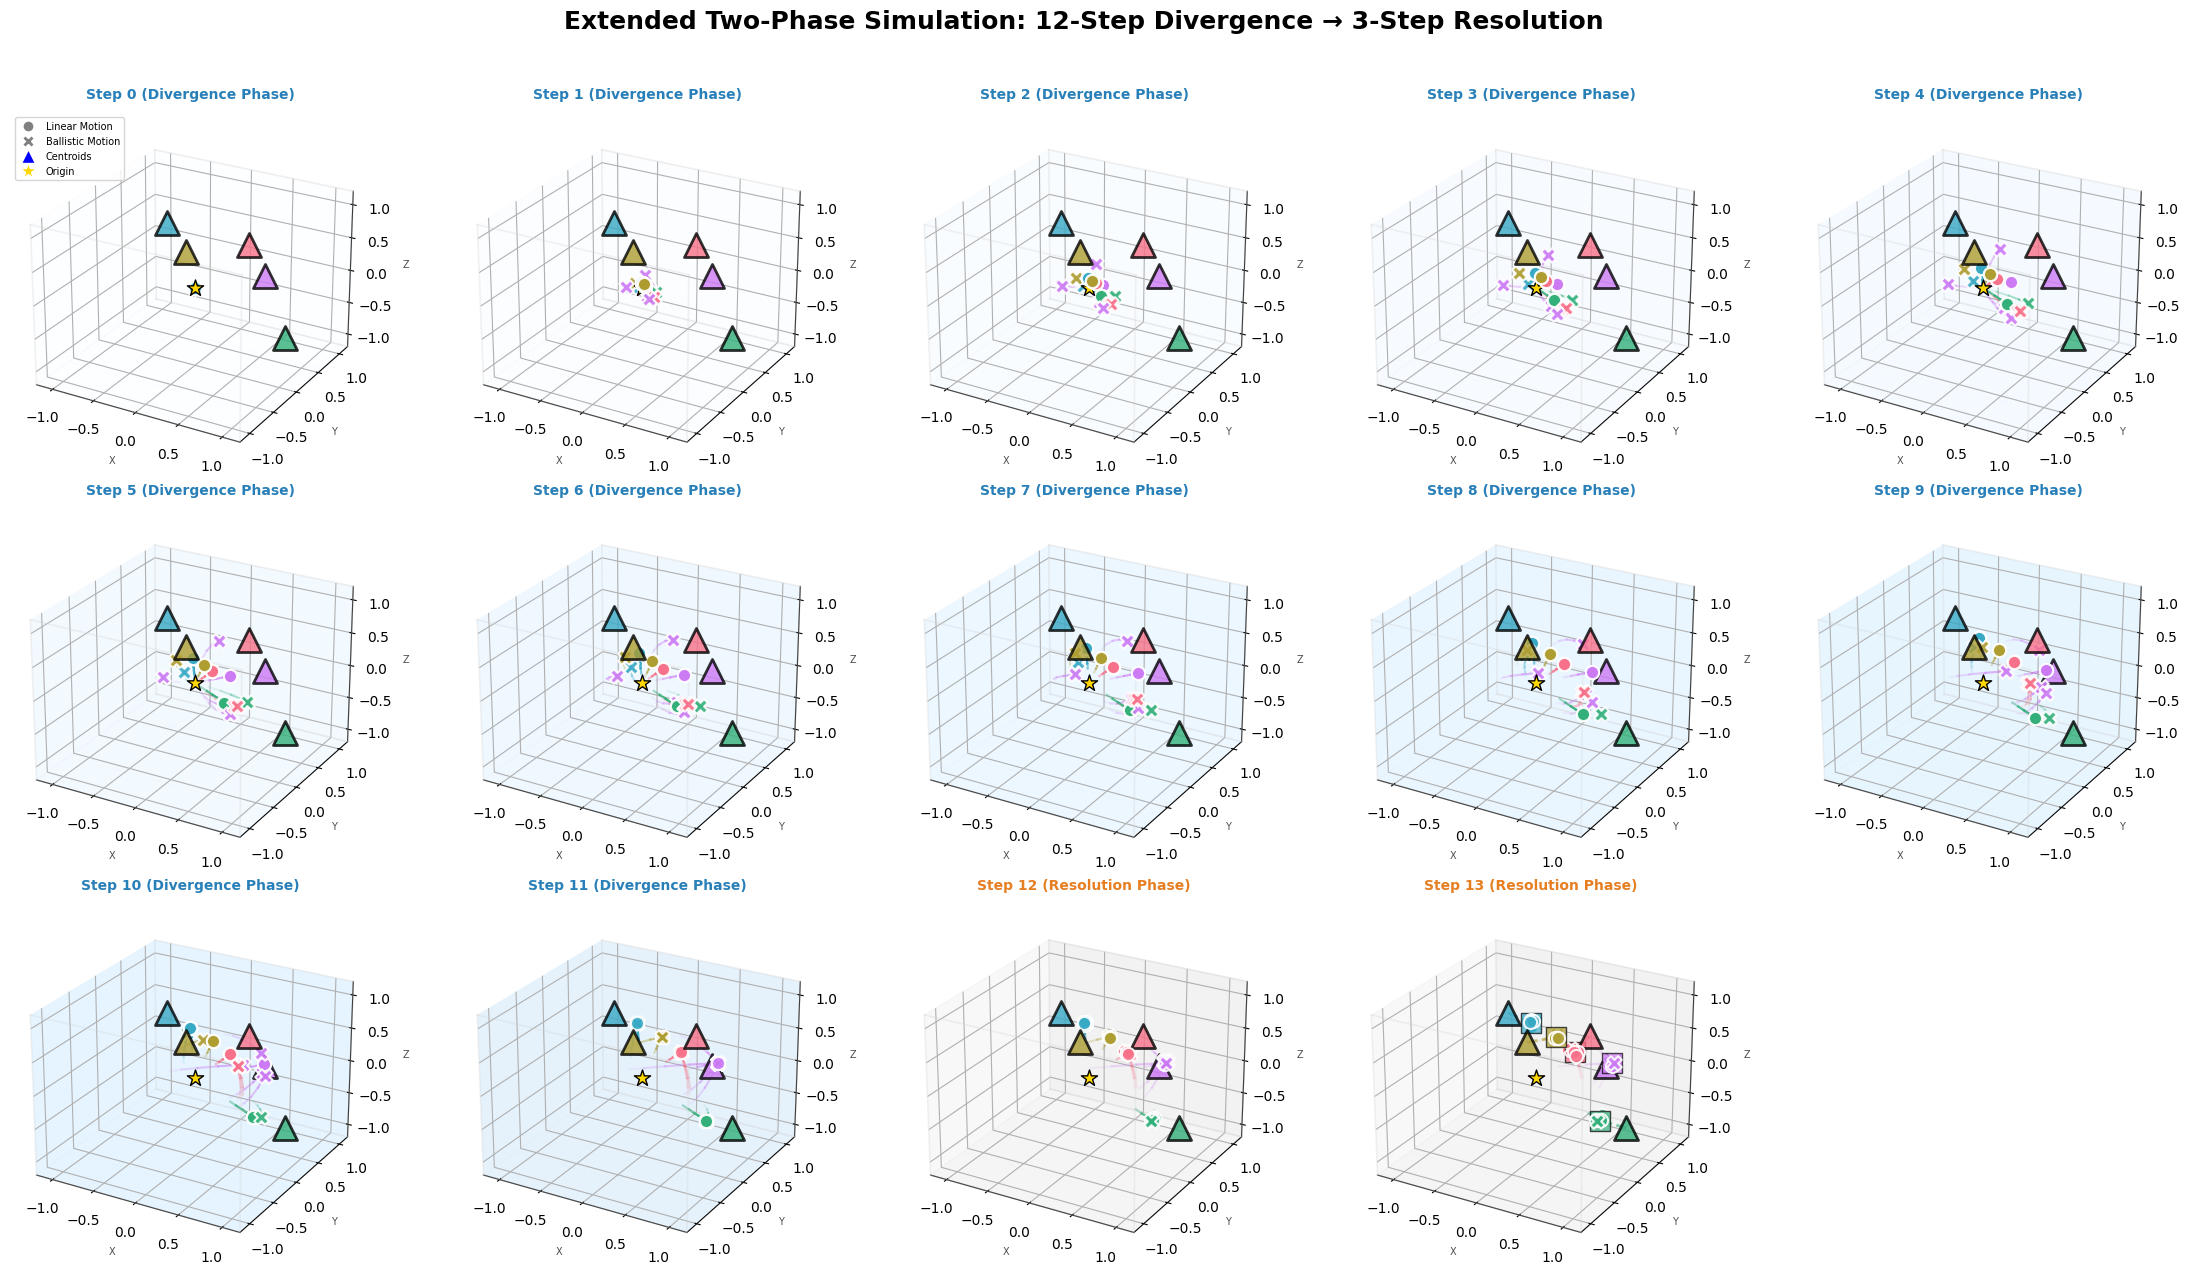

--- Neighbor-Joining Trees (Topology Resolving over Final Steps) ---


,Step,NJ_Newick
0,0,"(P3:0.0,P2:0.0,P4:0,P5:0,P6:0,P7:0,P8:0,P9:0,P..."
1,1,"(P28:0.0,P12:0.0,P31:0,P19:1.3704315460216776e..."
2,2,"(P28:0.0,P12:0.0,P31:0,P9:1.0408340855860843e-..."
3,3,"(P20:0.0,P12:0.0,P28:0,P31:2.3592239273284576e..."
4,4,"((((((((((P26:0.0,P24:0,P16:0,P0:0,P3:0):0.015..."
5,5,"(P31:0.0,P11:0.0,P9:0,P28:1.3877787807814457e-..."
6,6,"(P31:0.0,P11:0.0,P12:0,P9:0,P18:0,P28:0,P20:0,..."
7,7,"((((((((((P26:0.0,P24:6.579099405186112e-17,P1..."
8,8,"((((((((((((P26:0.0,P24:6.579099405186112e-17,..."
9,9,"((((((((((P26:0.0,P24:0,P16:1.2688263138573217..."


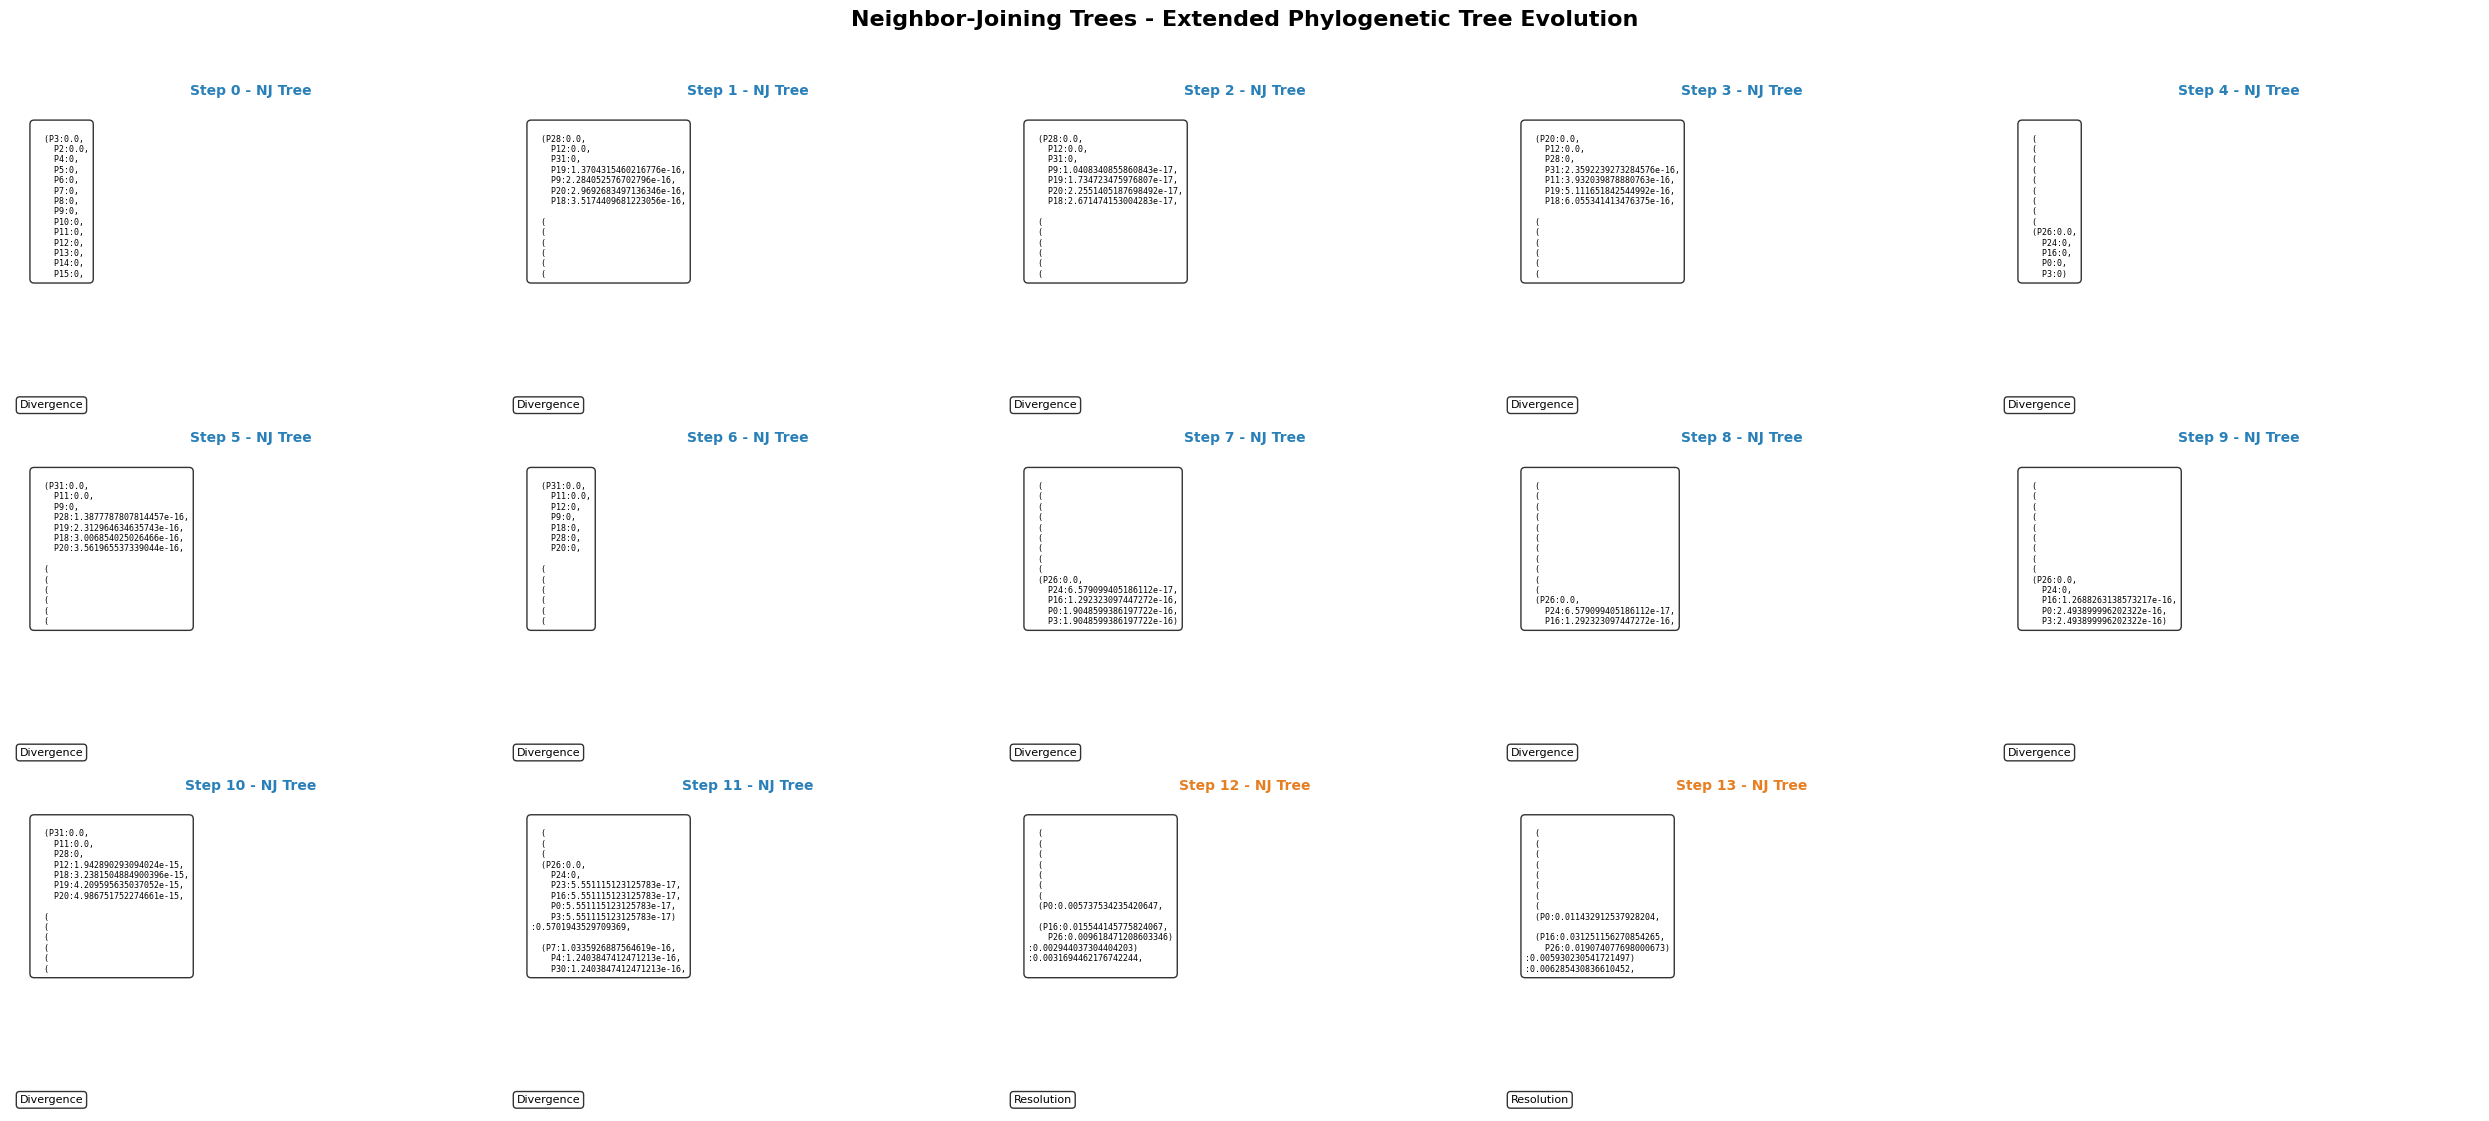

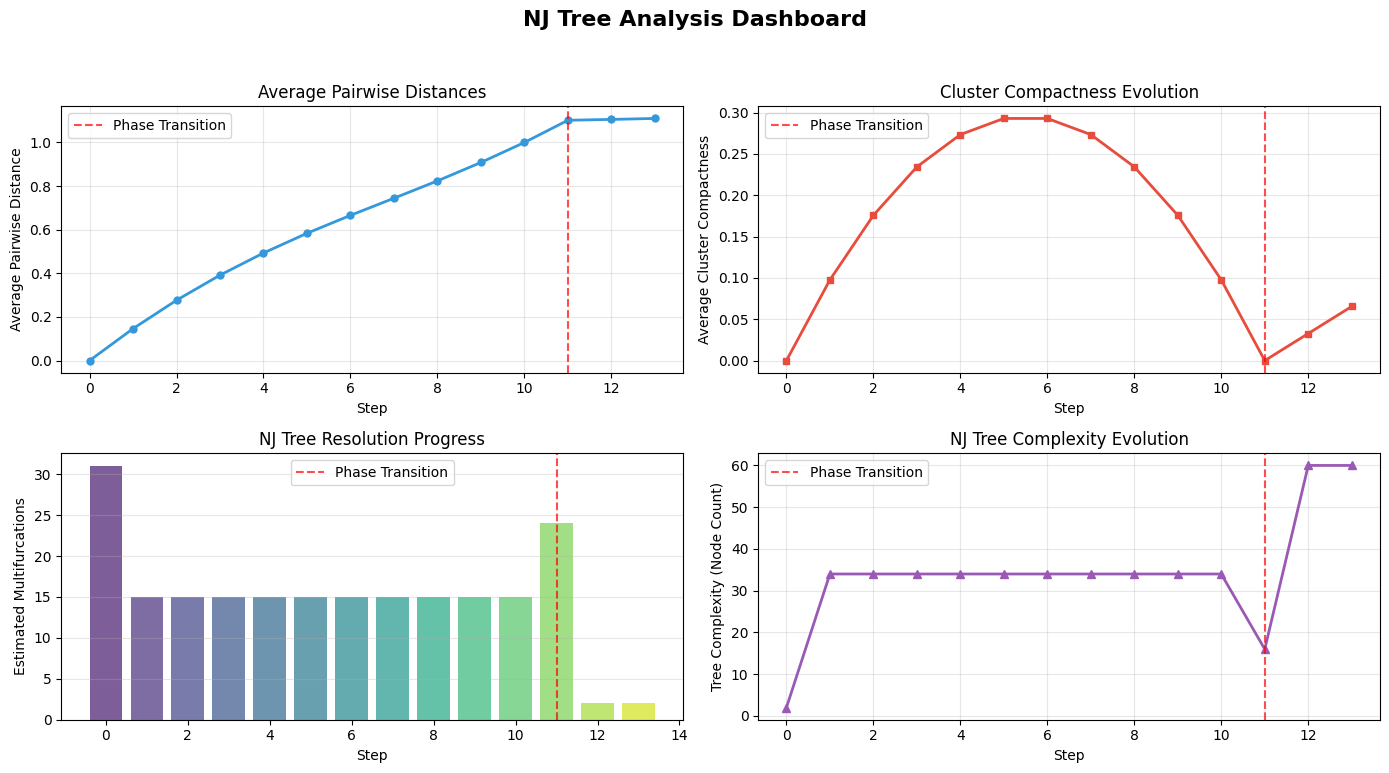

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy as sch
import pandas as pd
from IPython.display import display
import math
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch

# Import scikit-bio for neighbor-joining
from skbio import DistanceMatrix
from skbio.tree import nj

# -------------------- GLOBAL SETTINGS --------------------
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

N_POINTS, N_CENTROIDS = 32, 5
N_DIVERGENCE_STEPS = 12  # Steps for points to move to their targets (increased from 4 to 12)
N_RESOLUTION_STEPS = 3   # Steps to gradually add noise at the end
N_TOTAL_STEPS = N_DIVERGENCE_STEPS + N_RESOLUTION_STEPS

SIGMA_TARGET = 0.25
LINEAR_FRAC  = 0.7
AX_LIM       = 1.2
ENDPOINT_NOISE_STD = 0.03 # Controls the max noise added during the resolution phase

# --- NEW: Control which clusters move symmetrically ---
# For this test, all clusters will move symmetrically.
SYMMETRIC_CLUSTER_IDS = list(range(N_CENTROIDS))
# ---

# -------------------- BUILD SCENE ------------------------
centroids = rng.uniform(-1.3, 1.3, size=(N_CENTROIDS, 3))
clusters  = rng.integers(0, N_CENTROIDS, size=N_POINTS)

# --- MODIFIED FOR FLEXIBLE SYMMETRY ---
centroid_targets = centroids + rng.normal(0, SIGMA_TARGET, size=(N_CENTROIDS, 3))
individual_targets = centroids[clusters] + rng.normal(0, SIGMA_TARGET, size=(N_POINTS, 3))
is_symmetric_mask = np.isin(clusters, SYMMETRIC_CLUSTER_IDS)
targets = np.where(
    is_symmetric_mask[:, np.newaxis],
    centroid_targets[clusters],
    individual_targets
)
# --- END MODIFICATION ---

# --- PHASE 1: DIVERGENCE TRAJECTORY ---
modes = rng.choice([0, 1], size=N_POINTS, p=[LINEAR_FRAC, 1 - LINEAR_FRAC])
T_diverge = N_DIVERGENCE_STEPS - 1
v0 = rng.uniform(-0.2, 0.2, size=(N_POINTS, 3))
acc = np.zeros_like(v0)
ball = (modes == 1)
# Handle division by zero if T_diverge is 0
if T_diverge > 0:
    acc[ball] = 2 * (targets[ball] - v0[ball] * T_diverge) / (T_diverge**2)

t_vec_diverge = np.arange(N_DIVERGENCE_STEPS).reshape(1, N_DIVERGENCE_STEPS, 1)
if T_diverge > 0:
    linear_traj = targets[:, np.newaxis, :] * (t_vec_diverge / T_diverge)
else: # If only one step, it's just the target
    linear_traj = targets[:, np.newaxis, :]
ballistic_traj = (v0[:, np.newaxis, :] * t_vec_diverge) + (0.5 * acc[:, np.newaxis, :] * t_vec_diverge**2)
divergence_traj = np.where((modes == 1).reshape(N_POINTS, 1, 1), ballistic_traj, linear_traj)

# --- PHASE 2: TOPOLOGY RESOLUTION TRAJECTORY ---
# The starting point for this phase is the endpoint of the divergence phase.
start_pos_resolution = divergence_traj[:, -1, :]
# This is the final, total noise vector to be applied.
final_noise = rng.normal(0, ENDPOINT_NOISE_STD, size=(N_POINTS, 3))
# Create a scaling factor that ramps from 0 to 1 over the resolution steps.
noise_scaling = np.linspace(0, 1, N_RESOLUTION_STEPS)
# Create the resolution trajectory by adding scaled noise.
resolution_traj = start_pos_resolution[:, np.newaxis, :] + (final_noise[:, np.newaxis, :] * noise_scaling[np.newaxis, :, np.newaxis])

# --- COMBINE TRAJECTORIES ---
# We need to ensure we get exactly N_TOTAL_STEPS by taking all divergence steps
# and adding the resolution steps (the first resolution step has no noise, so it's the same as the last divergence step)
full_traj = np.concatenate((divergence_traj, resolution_traj[:, 1:, :]), axis=1)

# Debug: Print shape to verify
print(f"Expected steps: {N_TOTAL_STEPS}, Actual trajectory shape: {full_traj.shape}")

# -------------------- LIBRARY NJ & MULTIFURCATIONS ---------------------
def collapse_short_branches(tree, threshold=1e-6):
    while True:
        nodes_to_collapse = []
        for node in tree.postorder():
            if not node.is_tip() and node.length is not None and node.length < threshold:
                if node.parent:
                    nodes_to_collapse.append(node)
        if not nodes_to_collapse:
            break
        for node in nodes_to_collapse:
            if node.parent is None:
                continue
            parent = node.parent
            for child in node.children:
                child.length = (child.length or 0) + (node.length or 0)
            children = list(node.children)
            parent.remove(node)
            parent.extend(children)
    return tree

def library_neighbor_joining(D, labels, collapse_threshold=1e-6):
    dm = DistanceMatrix(D, labels)
    tree = nj(dm)
    tree = collapse_short_branches(tree, threshold=collapse_threshold)
    return str(tree)

def nj_tree_to_scipy_linkage(tree_str, labels):
    """Convert NJ tree string to scipy linkage format for dendrogram plotting"""
    try:
        # Parse the tree and extract distances for a simple dendrogram representation
        # This is a simplified approach - for complex trees, you'd want a proper parser
        from skbio import TreeNode
        tree = TreeNode.read(tree_str, format='newick')

        # Get distance matrix from tree
        n = len(labels)
        distances = np.zeros((n, n))

        # Calculate pairwise distances through the tree
        for i, label1 in enumerate(labels):
            node1 = tree.find(label1)
            if node1:
                for j, label2 in enumerate(labels):
                    if i != j:
                        node2 = tree.find(label2)
                        if node2:
                            distances[i, j] = node1.distance(node2)

        # Use UPGMA as fallback for dendrogram visualization
        Z = sch.linkage(squareform(distances), method='average')
        return Z
    except:
        # Fallback to distance-based linkage if tree parsing fails
        return None

def plot_nj_tree_text(ax, tree_str, step, transition_step):
    """Plot NJ tree as formatted text"""
    ax.clear()
    ax.axis('off')

    # Clean up the tree string for better display
    display_tree = tree_str.replace('(', '\n  (').replace(')', ')\n')
    display_tree = display_tree.replace(',', ',\n    ')

    # Split into lines and limit length
    lines = display_tree.split('\n')
    max_lines = 20  # Limit number of lines
    if len(lines) > max_lines:
        lines = lines[:max_lines-1] + ['...']

    # Color code by phase
    if step <= transition_step:
        ax.set_facecolor('#f8f9fa')
        phase_label = "Divergence"
        title_color = '#2980b9'
    else:
        ax.set_facecolor('#fff5f5')
        phase_label = "Resolution"
        title_color = '#e67e22'

    # Display tree text
    tree_text = '\n'.join(lines[:15])  # Limit to 15 lines
    ax.text(0.05, 0.95, tree_text, transform=ax.transAxes, fontsize=6,
           verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

    # Add title and phase indicator
    ax.set_title(f"Step {step} - NJ Tree", fontsize=10, fontweight='bold',
                pad=10, color=title_color)

    # Add phase indicator
    ax.text(0.02, 0.02, phase_label, transform=ax.transAxes, fontsize=8,
           verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3',
           facecolor='white', alpha=0.8))

labels = [f"P{k}" for k in range(N_POINTS)]


# -------------------- ENHANCED MOTION GRID ------------------------
# Set up enhanced color scheme
plt.style.use('default')  # Reset to default style
colors = sns.color_palette("husl", N_CENTROIDS)
pt_colors = [colors[c] for c in clusters]

# Create extended gradient background for phase transition (more colors for 12 steps)
phase_colors = ['#f0f8ff', '#e6f3ff', '#cce7ff', '#b3dbff', '#99d6ff', '#80ccff',
                '#66c2ff', '#4db8ff', '#33adff', '#1aa3ff', '#0099ff', '#0080e6',
                '#ffeaa7', '#fdcb6e', '#e17055']

# Use the actual number of steps from the trajectory
actual_steps = full_traj.shape[1]
n_cols = 5  # Use 5 columns for better layout with 15 steps
n_rows = math.ceil(actual_steps / n_cols)
fig = plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5), facecolor='white')

axes = [fig.add_subplot(n_rows, n_cols, i + 1, projection='3d') for i in range(actual_steps)]

def enhanced_cube_frame(ax, lim=AX_LIM, alpha=0.3):
    """Enhanced cube frame with gradient and better visibility"""
    # Main cube edges
    for s in (-lim, lim):
        ax.plot([s, s], [-lim, -lim], [-lim, lim], color='lightgray', ls='-', lw=1.2, alpha=alpha)
        ax.plot([s, s], [ lim,  lim], [-lim, lim], color='lightgray', ls='-', lw=1.2, alpha=alpha)
        ax.plot([-lim, lim], [s, s], [-lim, -lim], color='lightgray', ls='-', lw=1.2, alpha=alpha)
        ax.plot([-lim, lim], [s, s], [ lim,  lim], color='lightgray', ls='-', lw=1.2, alpha=alpha)

    # Additional grid lines for better depth perception
    for coord in np.linspace(-lim, lim, 5):
        ax.plot([coord, coord], [-lim, lim], [-lim, -lim], color='lightgray', ls=':', lw=0.5, alpha=alpha/2)
        ax.plot([-lim, lim], [coord, coord], [-lim, -lim], color='lightgray', ls=':', lw=0.5, alpha=alpha/2)

for step, ax in enumerate(axes):
    # Set background color based on phase
    transition_step = N_DIVERGENCE_STEPS - 1
    if step <= transition_step:
        ax.xaxis.pane.fill = True
        ax.yaxis.pane.fill = True
        ax.zaxis.pane.fill = True
        ax.xaxis.pane.set_facecolor(phase_colors[min(step, len(phase_colors)-1)])
        ax.yaxis.pane.set_facecolor(phase_colors[min(step, len(phase_colors)-1)])
        ax.zaxis.pane.set_facecolor(phase_colors[min(step, len(phase_colors)-1)])
        ax.xaxis.pane.set_alpha(0.1)
        ax.yaxis.pane.set_alpha(0.1)
        ax.zaxis.pane.set_alpha(0.1)

    plot_pos = full_traj[:, step, :]

    # Draw trajectory paths (fading previous positions)
    if step > 0:
        for i in range(N_POINTS):
            # Draw path from previous step with transparency
            prev_pos = full_traj[i, max(0, step-4):step+1, :]  # Show more history for longer trajectory
            if len(prev_pos) > 1:
                alpha_values = np.linspace(0.1, 0.7, len(prev_pos))
                for j in range(len(prev_pos)-1):
                    ax.plot([prev_pos[j, 0], prev_pos[j+1, 0]],
                           [prev_pos[j, 1], prev_pos[j+1, 1]],
                           [prev_pos[j, 2], prev_pos[j+1, 2]],
                           color=pt_colors[i], alpha=alpha_values[j], lw=1.5)

    # Plot current positions with enhanced markers
    for i in range(N_POINTS):
        marker = 'o' if modes[i] == 0 else 'X'
        size = 90 if modes[i] == 0 else 110
        # Add white edge for better visibility
        ax.scatter(*plot_pos[i], color=pt_colors[i], marker=marker, s=size,
                  edgecolor='white', linewidth=1.5, alpha=0.9)

        # Add point labels for better tracking (optional, only for first few points)
        if N_POINTS <= 16 and step == actual_steps - 1:  # Only on final step for clarity
            ax.text(plot_pos[i, 0], plot_pos[i, 1], plot_pos[i, 2] + 0.1,
                   f'P{i}', fontsize=6, ha='center', va='bottom', alpha=0.7)

    # Enhanced centroid visualization
    for j, centroid in enumerate(centroids):
        ax.scatter(*centroid, s=300, marker='^', color=colors[j],
                  edgecolor='black', linewidth=2, alpha=0.8, label=f'C{j}' if step == 0 else "")

        # Draw connection lines from centroids to their targets
        if step == actual_steps - 1:  # Only on final step
            target = centroid_targets[j]
            ax.plot([centroid[0], target[0]], [centroid[1], target[1]],
                   [centroid[2], target[2]], color=colors[j], ls='--', lw=2, alpha=0.6)
            ax.scatter(*target, s=200, marker='s', color=colors[j],
                      edgecolor='black', linewidth=1, alpha=0.7)

    # Origin marker
    ax.scatter(0, 0, 0, marker='*', color='gold', s=150, edgecolor='black', linewidth=1)

    enhanced_cube_frame(ax)
    ax.set_xlim(-AX_LIM, AX_LIM)
    ax.set_ylim(-AX_LIM, AX_LIM)
    ax.set_zlim(-AX_LIM, AX_LIM)

    # Enhanced title with phase information
    title = f"Step {step}"
    if step <= transition_step:
        title += " (Divergence Phase)"
        title_color = '#2980b9'
    else:
        title += " (Resolution Phase)"
        title_color = '#e67e22'

    ax.set_title(title, fontsize=10, fontweight='bold', color=title_color, pad=10)
    ax.view_init(elev=25, azim=-60)

    # Remove axis for cleaner look but add subtle grid
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X', fontsize=7, alpha=0.7)
    ax.set_ylabel('Y', fontsize=7, alpha=0.7)
    ax.set_zlabel('Z', fontsize=7, alpha=0.7)

# Add legend to first subplot
if len(axes) > 0:
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Linear Motion'),
        plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', markersize=8, label='Ballistic Motion'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Centroids'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markersize=12, label='Origin')
    ]
    axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), fontsize=7)

fig.suptitle("Extended Two-Phase Simulation: 12-Step Divergence → 3-Step Resolution",
             fontsize=18, fontweight='bold', y=0.96)
plt.tight_layout(rect=[0, 0.02, 1, 0.94])
plt.show()

# -------------------- NJ NEWICK PER STEP -----------------
nj_trees = [
    library_neighbor_joining(squareform(pdist(full_traj[:, s, :])), labels)
    for s in range(actual_steps)
]
df = pd.DataFrame({"Step": range(actual_steps), "NJ_Newick": nj_trees})
print("--- Neighbor-Joining Trees (Topology Resolving over Final Steps) ---")
display(df)

# -------------------- NJ TREE VISUALIZATION GRID --------------
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
if n_rows == 1:
    axes2 = [axes2] if n_cols == 1 else axes2
else:
    axes2 = axes2.flatten()

# Hide any extra axes if the grid is larger than the number of steps
for i in range(actual_steps, len(axes2)):
    axes2[i].axis('off')

# Enhanced color scheme
dendrogram_colors = sns.color_palette("viridis", actual_steps)
transition_step = N_DIVERGENCE_STEPS - 1

for step, ax in enumerate(axes2[:actual_steps]):
    # Plot NJ tree as text representation
    plot_nj_tree_text(ax, nj_trees[step], step, transition_step)

fig2.suptitle("Neighbor-Joining Trees - Extended Phylogenetic Tree Evolution",
              fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0.02, 1, 0.93])
plt.show()

# -------------------- SUMMARY STATISTICS VISUALIZATION --------------
fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))

# 1. Average pairwise distances over time
avg_distances = []
for step in range(actual_steps):
    distances = pdist(full_traj[:, step, :])
    avg_distances.append(np.mean(distances))

ax1.plot(range(actual_steps), avg_distances, 'o-', linewidth=2, markersize=5, color='#3498db')
ax1.axvline(x=N_DIVERGENCE_STEPS-1, color='red', linestyle='--', alpha=0.7, label='Phase Transition')
ax1.set_xlabel('Step')
ax1.set_ylabel('Average Pairwise Distance')
ax1.set_title('Average Pairwise Distances')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Cluster compactness over time
cluster_compactness = []
for step in range(actual_steps):
    compactness = []
    for cluster_id in range(N_CENTROIDS):
        cluster_points = full_traj[clusters == cluster_id, step, :]
        if len(cluster_points) > 1:
            cluster_distances = pdist(cluster_points)
            compactness.append(np.mean(cluster_distances))
    cluster_compactness.append(np.mean(compactness) if compactness else 0)

ax2.plot(range(actual_steps), cluster_compactness, 's-', linewidth=2, markersize=5, color='#e74c3c')
ax2.axvline(x=N_DIVERGENCE_STEPS-1, color='red', linestyle='--', alpha=0.7, label='Phase Transition')
ax2.set_xlabel('Step')
ax2.set_ylabel('Average Cluster Compactness')
ax2.set_title('Cluster Compactness Evolution')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Number of multifurcations in NJ trees
multifurcation_counts = []
for tree_str in nj_trees:
    # Count commas to estimate polytomies (simplified approach)
    multifurcation_counts.append(tree_str.count(',') - tree_str.count('(') + 1)

ax3.bar(range(actual_steps), multifurcation_counts, color=dendrogram_colors[:actual_steps], alpha=0.7)
ax3.axvline(x=N_DIVERGENCE_STEPS-1, color='red', linestyle='--', alpha=0.7, label='Phase Transition')
ax3.set_xlabel('Step')
ax3.set_ylabel('Estimated Multifurcations')
ax3.set_title('NJ Tree Resolution Progress')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend()

# 4. Tree topology complexity over time
tree_complexity = []
for tree_str in nj_trees:
    # Measure tree complexity by counting total nodes
    complexity = tree_str.count('(') + tree_str.count(')')
    tree_complexity.append(complexity)

ax4.plot(range(actual_steps), tree_complexity, '^-', linewidth=2, markersize=6, color='#9b59b6')
ax4.axvline(x=N_DIVERGENCE_STEPS-1, color='red', linestyle='--', alpha=0.7, label='Phase Transition')
ax4.set_xlabel('Step')
ax4.set_ylabel('Tree Complexity (Node Count)')
ax4.set_title('NJ Tree Complexity Evolution')
ax4.grid(True, alpha=0.3)
ax4.legend()

fig3.suptitle('NJ Tree Analysis Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()

Phylogenetic Simulation Starting...
Configuration: 32 points, 5 centroids
Two-phase motion: 12 divergence + 3 resolution steps
Generated trajectory shape: (32, 14, 3)

--- Neighbor-Joining Trees (Topology Evolution) ---
 Step                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/Users/berksakalli/Projects/BranchArchitect/.venv/lib/python3.11/site-packages/skbio/util/_warning.py:40: FutureWarning: The default behavior of `root_at_midpoint` is subject to change in 0.7.0. The new default behavior can be achieved by specifying `reset=True, branch_attrs=[], root_name=None`.
  warn(message, warning)


Displayed interactive 3D trajectory animation


Displayed 14 interactive trees out of 14 total trees
Saved analytics dashboard to: analytics_dashboard.png


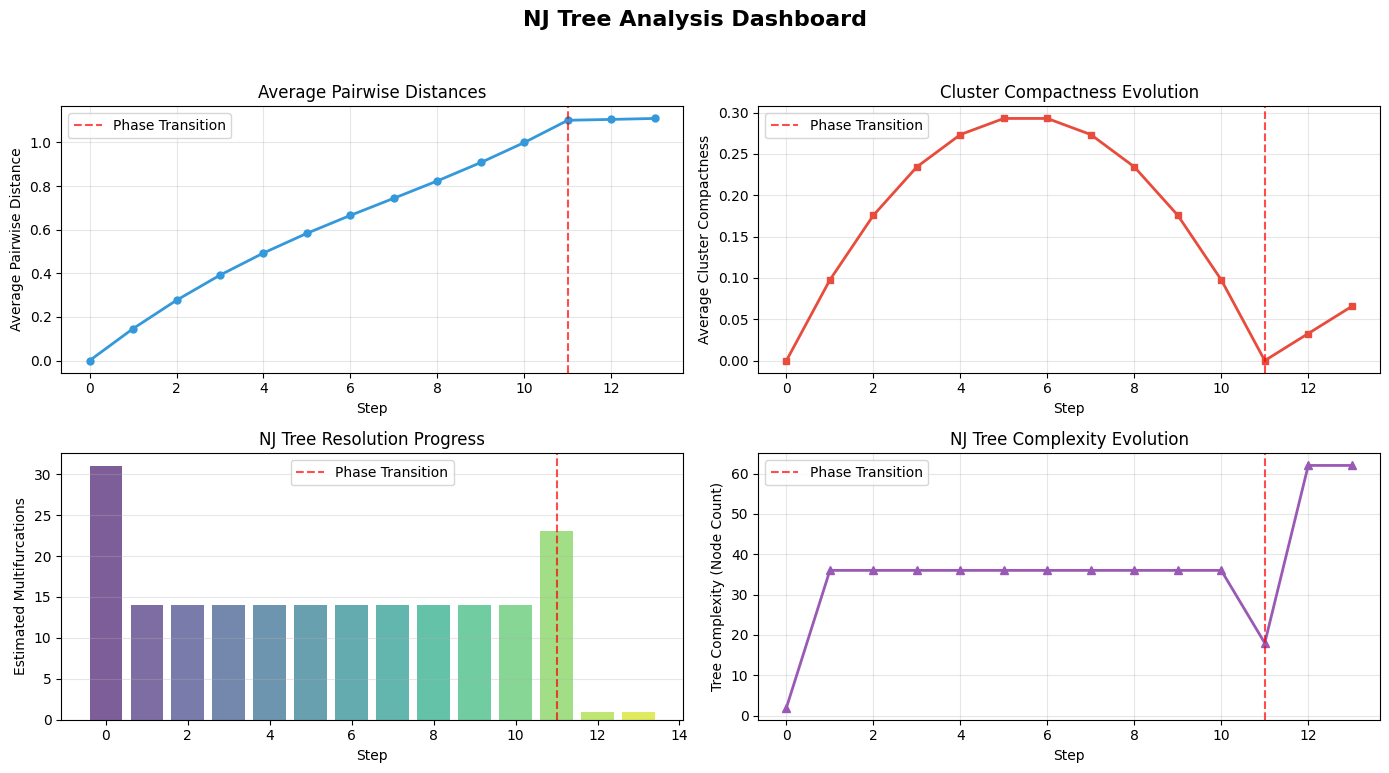

Simulation complete!
Simulation complete!
Trajectory shape: (32, 14, 3)
Number of NJ trees: 14
Number of centroids: 5
Number of clusters: 5


In [1]:
# Import the compact phylo simulation module
import sys
import os

# Add the parent directory to Python path so we can import the module
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath('.'))))

# Import the simulation module
import compact_phylo_simulation as cps

# Run the simulation
results = cps.run_simulation()

# Access the results
trajectory = results['trajectory']
nj_trees = results['nj_trees']
centroids = results['centroids']
clusters = results['clusters']
modes = results['modes']

print(f"Simulation complete!")
print(f"Trajectory shape: {trajectory.shape}")
print(f"Number of NJ trees: {len(nj_trees)}")
print(f"Number of centroids: {len(centroids)}")
print(f"Number of clusters: {len(set(clusters))}")

Phylogenetic Simulation Starting...
Configuration: 20 points, 3 centroids
Two-phase motion: 8 divergence + 2 resolution steps
Generated trajectory shape: (20, 9, 3)

--- Neighbor-Joining Trees (Topology Evolution) ---
 Step                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Displayed interactive 3D trajectory animation


Displayed 9 interactive trees out of 9 total trees
Saved analytics dashboard to: analytics_dashboard.png


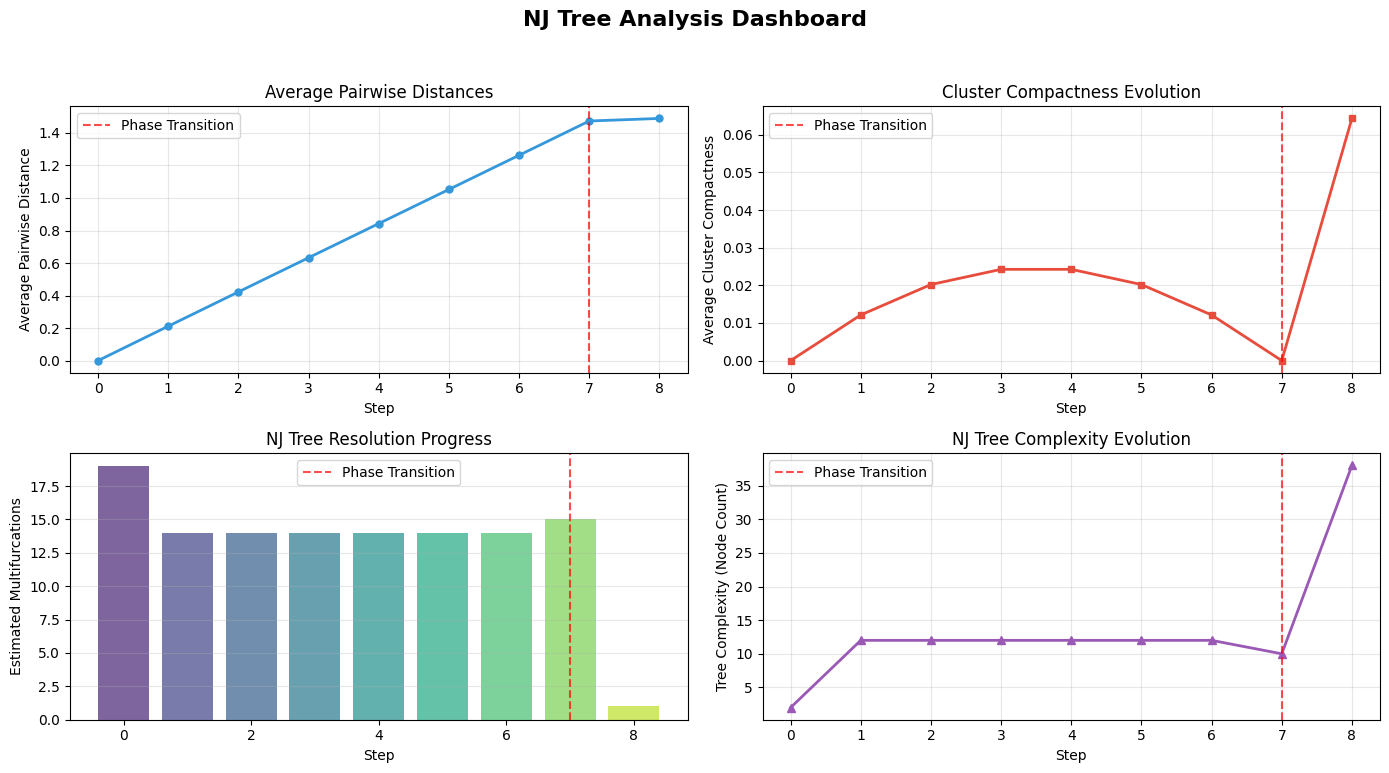

Simulation complete!
Custom simulation complete!
Custom trajectory shape: (20, 9, 3)
Custom number of steps: 9


In [2]:
# You can also customize the simulation by modifying the module's parameters before running
import compact_phylo_simulation as cps

# Save original parameters
original_n_points = cps.N_POINTS
original_n_centroids = cps.N_CENTROIDS
original_n_divergence = cps.N_DIVERGENCE_STEPS
original_n_resolution = cps.N_RESOLUTION_STEPS

# Customize parameters for a different simulation
cps.N_POINTS = 20  # Fewer points
cps.N_CENTROIDS = 3  # Fewer clusters
cps.N_DIVERGENCE_STEPS = 8  # Shorter divergence phase
cps.N_RESOLUTION_STEPS = 2  # Shorter resolution phase
cps.N_TOTAL_STEPS = cps.N_DIVERGENCE_STEPS + cps.N_RESOLUTION_STEPS
# Run customized simulation
custom_results = cps.run_simulation()

# Restore original parameters
cps.N_POINTS = original_n_points
cps.N_CENTROIDS = original_n_centroids
cps.N_DIVERGENCE_STEPS = original_n_divergence
cps.N_RESOLUTION_STEPS = original_n_resolution
cps.N_TOTAL_STEPS = cps.N_DIVERGENCE_STEPS + cps.N_RESOLUTION_STEPS

print(f"Custom simulation complete!")
print(f"Custom trajectory shape: {custom_results['trajectory'].shape}")
print(f"Custom number of steps: {custom_results['trajectory'].shape[1]}")